# Binary classification project: Supervised learning

- The objective of this project is to develop a supervised learning model that can predict financial risk for agricultural enterprises. 

- The dataset farm_data_train.csv for training contains farms which are categorized into two groups: 'healthy' and 'defaulting' farms. 

- The aim is to construct a financial risk detection score applicable to agricultural operations. For this purpose, a set of financial ratios has been measured for each agricultural operation (R2, R14, R17, R32).

In [1]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from classification_workflow import *
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns

# Exploring the dataset
**The first step is to explore the data to make sure whether it is clean or contains outliers.**

In [2]:
#Explore the data 
farm= pd.read_csv('farm_data_train.csv') # read the training data 
farm.head() #Print the first 5 elements of the data
farm.info() #Give information about the data
nan_count = farm[farm.isna().any(axis=1)].shape[0] #Caculate the number of non-values present in the data
print(f"Number of rows : {len(farm)}")
print(f"Number of rows with at least one NAN value: {nan_count}")
print(f"{round(nan_count/len(farm) * 100)}% of our rows have at least one"
      f" missing value")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R2      945 non-null    float64
 1   R14     945 non-null    float64
 2   R17     945 non-null    float64
 3   R32     945 non-null    float64
 4   DIFF    945 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 37.0 KB
Number of rows : 945
Number of rows with at least one NAN value: 0
0% of our rows have at least one missing value


In [3]:
farm.describe().T

count      mean       std      min     25%     50%     75%     max
R2    945.0  0.524635  0.287329  0.00000  0.3350  0.5800  0.7550  0.9540
R14   945.0  0.690901  0.634007 -0.68500  0.2169  0.4475  1.0050  2.9695
R17   945.0  0.064560  0.025861  0.00599  0.0450  0.0623  0.0823  0.1940
R32   945.0  0.252643  0.117565 -0.16200  0.1758  0.2687  0.3384  0.4881
DIFF  945.0  0.478307  0.499794  0.00000  0.0000  0.0000  1.0000  1.0000

In [4]:
farm.sample(6)

R2      R14     R17     R32  DIFF
384  0.492  0.68140  0.0685  0.2360     1
352  0.488  0.18090  0.0554  0.2699     0
804  0.914  0.23810  0.0303  0.2814     0
758  0.950  0.07379  0.0202  0.2670     0
912  0.683  1.57060  0.0303  0.2342     1
40   0.926  0.33530  0.0586  0.4009     0

In [5]:
#Check missing data
missing_data = farm.isnull().sum()
print("\nMissing data:")
print(missing_data)
#No missing data



Missing data:
R2      0
R14     0
R17     0
R32     0
DIFF    0
dtype: int64


**Comment: The data doesn't contain NaN values. There's no missed values.**

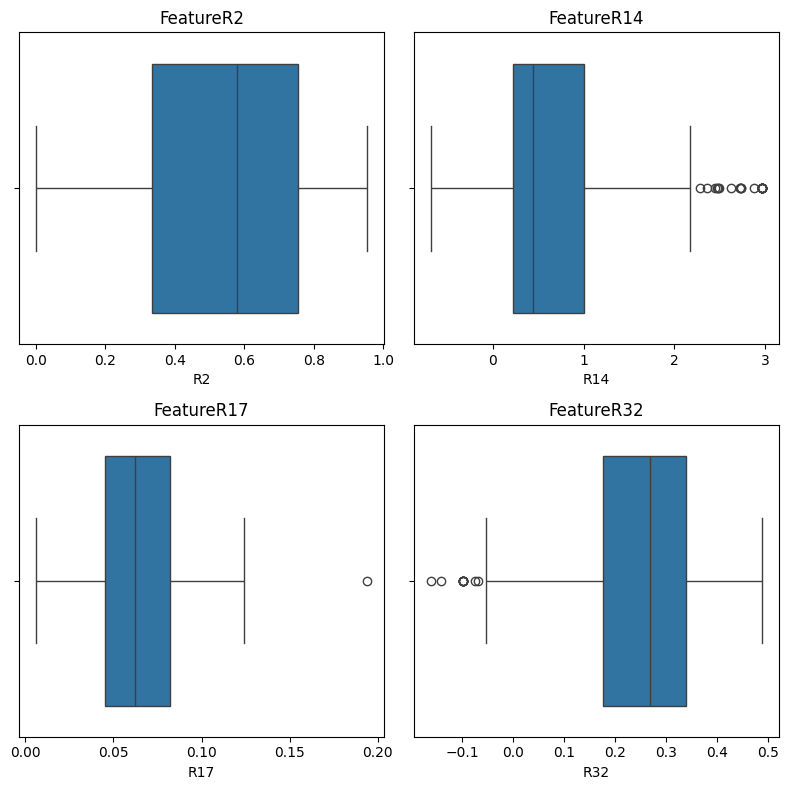

In [6]:
#Sans apploquer le logarithme
num_feature = ['R2', 'R14', 'R17', 'R32']
num_rows = 2
num_columns = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize =(8, 8))
axes = axes.flatten()
for i in range(len(num_feature), len(axes)):
    fig.delaxes(axes[i])

for i in range (len(num_feature)):
    sns.boxplot(data =farm, x= farm[num_feature[i]], ax = axes[i])
    axes[i].set_title(f"Feature{num_feature[i]}")

plt.tight_layout()
plt.show()

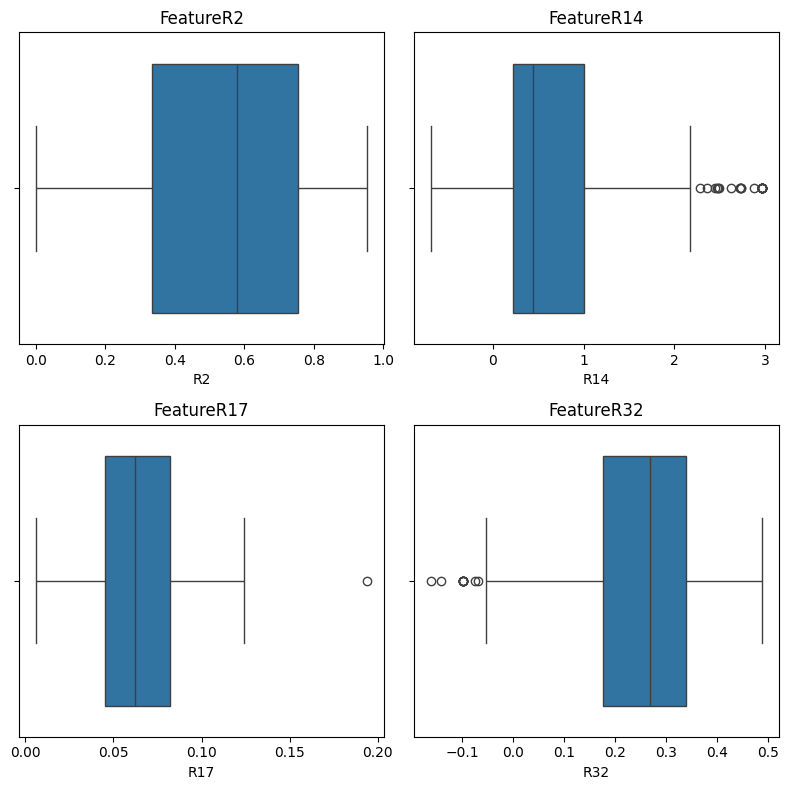

In [7]:
#Après avoir appliqué le logarithme
#Sans apploquer le logarithme
num_feature = ['R2', 'R14', 'R17', 'R32']
num_rows = 2
num_columns = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize =(8, 8))
axes = axes.flatten()
for i in range(len(num_feature), len(axes)):
    fig.delaxes(axes[i])

for i in range (len(num_feature)):
    sns.boxplot(data =farm, x= farm[num_feature[i]], ax = axes[i])
    axes[i].set_title(f"Feature{num_feature[i]}")

plt.tight_layout()
plt.show()

**Comment: R14 and R32 contain outliers ( circles)**.

### Outliers detection
Here I can add a function to detect the outliers in the data

In [8]:
#Find outliers
#calul de Q1 et Q3 puis faire la différence
#Pour R14
norm_upper_limit = farm["R14"].mean() + 3 * farm["R14"].std()
norm_lower_limit = farm["R14"].mean() -3 * farm["R14"].std()
#Trimming 
new_farm = farm[(farm["R14"]> norm_lower_limit) & (farm["R14"]< norm_upper_limit)]
#new_farm.sample(6)



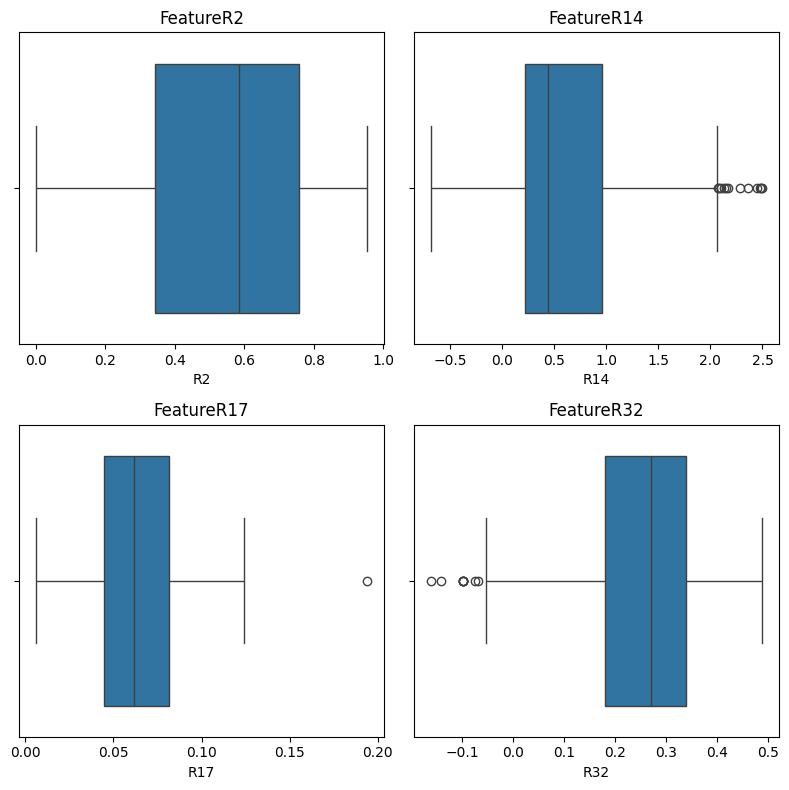

In [9]:
num_feature = ['R2', 'R14', 'R17', 'R32']
num_rows = 2
num_columns = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize =(8, 8))
axes = axes.flatten()
for i in range(len(num_feature), len(axes)):
    fig.delaxes(axes[i])

for i in range (len(num_feature)):
    sns.boxplot(data =new_farm, x= new_farm[num_feature[i]], ax = axes[i])
    axes[i].set_title(f"Feature{num_feature[i]}")

plt.tight_layout()
plt.show()

In [10]:
#calcul de Q1 et Q2
Q1 = farm["R14"].quantile(0.25)
#Calcul de Q2
Q2 = farm["R14"].quantile(0.75) 
#IQR 
IQR = Q2 -Q1
max_limit = Q2 + (1.5 * IQR)
min_limit = Q1 - (1.5 * IQR) 
#capping
new_data = pd.DataFrame(np.where(farm["R14"] > max_limit, max_limit, 
         (np.where(farm["R14"] < min_limit, min_limit, farm["R14"]))), columns=["R14"])
new_data.sample(6)
print(len(farm))
print(len(new_data))
#


945
945


### For R14
1. We have 23 outliers for R14
Apres anchof kifach n rexcuperer les indices o ntraiter les aberrants bohdhom

In [11]:
df1= pd.read_csv('farm_data_train.csv')
#df = df1["R2"]
outliers_index = []
df = farm.drop(['DIFF', 'R32', 'R2', 'R17'],axis=1)
#print(df)
for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrer les données pour trouver les outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers_index.append(outliers)
    print(f"Outliers in {column}:\n{outliers}\n")
print(len(outliers))

Outliers in R14:
        R14
320  2.2858
511  2.9695
512  2.8781
533  2.4761
596  2.3615
608  2.9695
611  2.4815
616  2.7281
626  2.9695
628  2.7242
629  2.9695
678  2.9695
681  2.6314
683  2.9695
695  2.9695
697  2.7331
700  2.7332
702  2.9695
703  2.9695
716  2.9695
717  2.4472
719  2.4964
722  2.9695

23


### For R14

In [12]:
num_feature = ['R14']
num_rows = 2
num_columns = 2
fig, axes = plt.subplots(num_rows, num_columns, figsize =(8, 8))
axes = axes.flatten()
for i in range(len(num_feature), len(axes)):
    fig.delaxes(axes[i])

for i in range (len(num_feature)):
    sns.boxplot(data =new_data, x= new_data[num_feature[i]], ax = axes[i])
    axes[i].set_title(f"Feature{num_feature[i]}")

plt.tight_layout()
plt.show()

**Histograms representing the frequency of variables**

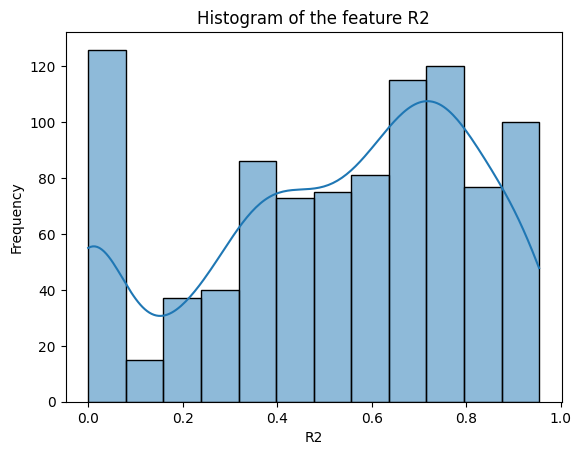

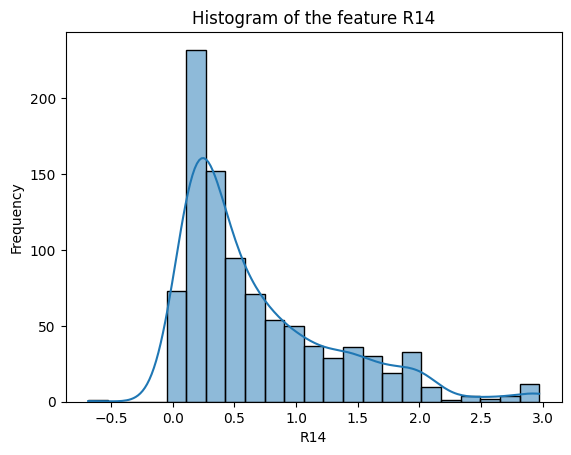

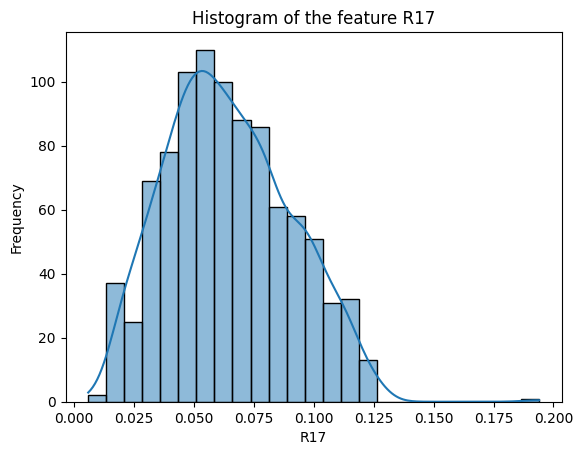

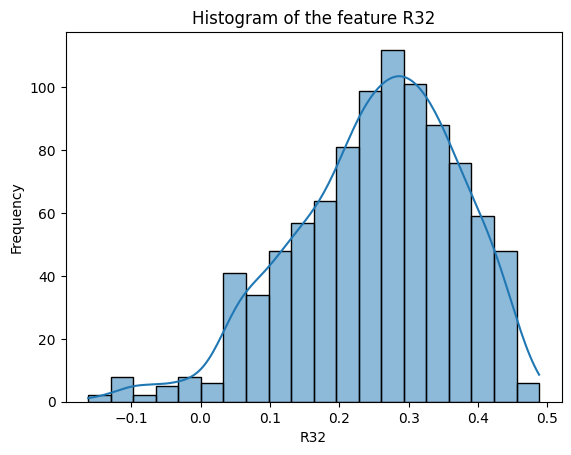

In [13]:
#Visualize the data
columns = farm.iloc[:,:-1].select_dtypes(include=['int64', 'float64']).columns.tolist()
if not columns :
        farm.hist(bins=10, figsize=(15, 10))
        plt.suptitle('Distribution of Numerical Columns', y=0.92)
        plt.show()
else :
        for c in columns :
            # Plot a histogram
            sns.histplot(farm[c], kde=True)
            plt.title(f'Histogram of the feature {str(c)}')
            plt.xlabel(str(c))
            plt.ylabel('Frequency')
            plt.show()

**Counting the number of 0 and 1 in DIFF variable** 

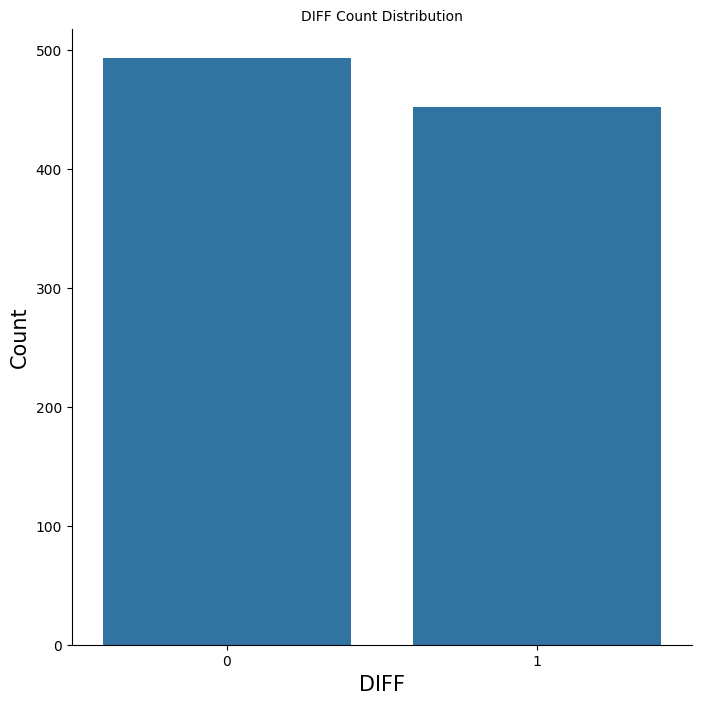

In [14]:
#Histogram of DIFF, count the number of 0 and 1 in the data
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
sns.countplot(x = 'DIFF', data = farm)
ax.set_xlabel('DIFF', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('DIFF Count Distribution', fontsize=10)
sns.despine()

**Correlation matrix**

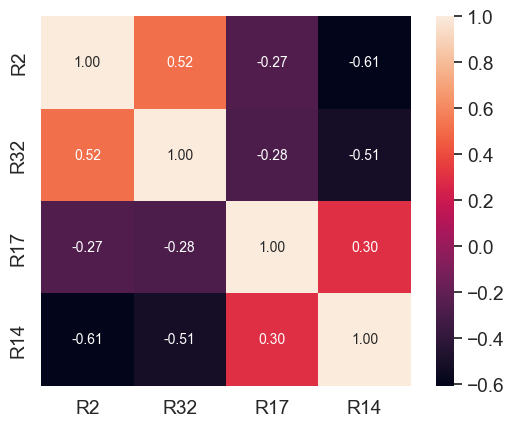

In [15]:
#Correlation matrix
k = 10 #number of variables for heatmap
import numpy as np
farm_final = farm[['R2', 'R14', 'R17','R32']]
corrmat = farm_final.corr()
cols = corrmat.nlargest(k, 'R2')['R2'].index
cm = np.corrcoef(farm[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Pairplot matrix**

In [16]:
#Pairplot matrix (Matrice de dispersion)
pp=sns.pairplot(farm, hue='DIFF', corner=False)

## Comment on pairplot matrix

## Commentaire: 
La matrice de scatter plots montre montre la relation entre les variables R2, R14, R17, R32.
1. Les histogrammes sur la diagonale montrent la distribution de chaque variable. Par exemple, R2 semble avoir une distribution bimodale, tandis que R14 a une distribution plus proche de la normale mais avec une queue sur la droite. R17 et R32 semblent également avoir des distributions légèrement asymétriques.

2.  Les scatter plots hors diagonale montrent la relation entre deux variables. Par exemple, il semble y avoir une corrélation positive entre R2 et R14, indiquée par la tendance des points à augmenter ensemble.

3. Présence de Valeurs Aberrantes : Il y a des points qui sont éloignés du regroupement principal dans plusieurs scatter plots, ce qui pourrait indiquer la présence de valeurs aberrantes. Par exemple, dans le scatter plot de R2 vs. R14, vous pouvez voir quelques points qui sont loin de la majorité des autres points.


# Standardization & Normalization

## Reminder

1. MinMaxScaler:

$$ X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} $$

2. StandardScaler:

$$ X_{\text{scaled}} = \frac{X - \mu}{\sigma} $$

3. RobustScaler:

$$ X_{\text{scaled}} = \frac{X - \text{médiane}}{\text{IQR}} $$

- $\text{IQR}$: interquartile range.

In [17]:
#minmax, standard, robust 
minmax, standard, robust = standardization(farm)
#print(robust)


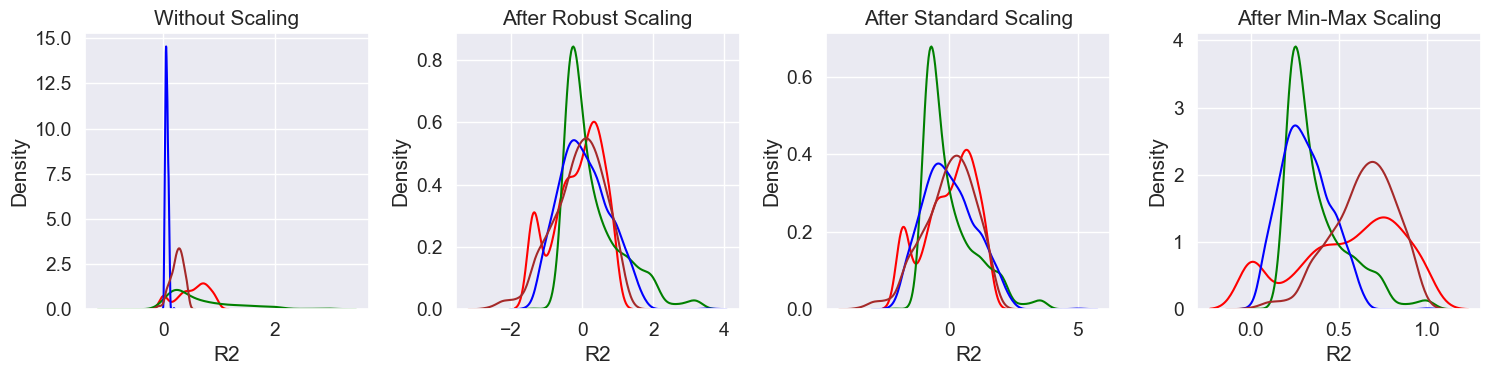

In [18]:
#Plot the densities of R2, R14, R17, R32 before and after scaling
plot_densities(farm)

### Commentaire
1. Sans Mise à l'Échelle : La distribution originale de R2 semble très concentrée avec un pic très marqué. Cela pourrait être dû à la présence de valeurs aberrantes ou à une échelle qui n'est pas alignée avec les autres variables.

2. Après Mise à l'Échelle **Robuste (Robust Scaling)** : La mise à l'échelle robuste utilise la médiane et l'intervalle interquartile (IQR) pour centrer et échelonner les données, ce qui la rend moins sensible aux valeurs aberrantes. La distribution de R2 après cette mise à l'échelle semble moins concentrée autour d'une seule valeur et s'étend sur un intervalle plus large, ce qui indique que l'échelle est maintenant plus robuste aux valeurs extrêmes.

3. Après Mise à l'Échelle Standard (Standard Scaling) : La mise à l'échelle standard soustrait la moyenne et divise par l'écart-type. Cette méthode est sensible aux valeurs aberrantes car elles influencent la moyenne et l'écart-type. Après cette mise à l'échelle, R2 montre une distribution qui semble centrée autour de zéro et s'étend à peu près également des deux côtés, indiquant que les données sont maintenant sur une échelle où la moyenne est 0 et l'écart-type est 1.

4. Après Mise à l'Échelle Min-Max : La mise à l'échelle Min-Max transforme les données pour qu'elles se situent dans un intervalle fixe, généralement [0, 1]. La distribution après cette mise à l'échelle montre que les données sont resserrées dans un intervalle plus petit et que le pic précédent est moins prononcé. Cela peut être utile lorsque les algorithmes nécessitent des données dans un intervalle spécifique.

### Interprétation globale: 

1. Les différentes méthodes de mise à l'échelle affectent la distribution de la variable R2 de manières différentes.
2. La mise à l'échelle robuste semble réduire l'effet des valeurs aberrantes, ce qui est souvent souhaitable pour les modèles qui sont sensibles à ces valeurs extrêmes.
3. La mise à l'échelle standard uniformise les données selon une distribution centrée autour de zéro, ce qui est utile pour des algorithmes comme la régression linéaire ou logistique, les SVM, et les réseaux de neurones.
4. La mise à l'échelle Min-Max est utile pour les algorithmes sensibles à l'échelle des attributs, comme les réseaux de neurones ou les algorithmes qui utilisent des mesures de distance comme KNN.





A dictonnary containing the models we try to evaluate, is defined above.
The models evaluated **for the moment** are: 
1. Logistic regression.
2. Random forests.
3. SVM.
4. kneighbors.
5. Decision tree.

In [19]:
dict_models = {'Logistic Regression': {
        'model': LogisticRegression(),
        'param_grid': {
            'C': [0.0001, 0.01, 0.1, 1, 10, 100], # regulirization (inverse of lambda)
            'fit_intercept': [True, False],  # True = interception is added (b0: biais)
            'intercept_scaling': [1, 10, 100, 150]  # Traiter le déséquilibre de la répartiotion des classes de la data, liblinear solver
        } 
    }
}

# Binary classification

Here, the strategy is to try to train the models using diffrent scaled data ie: 
1. Without scaling.
2. Robust data.
3. standard data.
4. Using Min-Max normalization.

### Without scaling

In [20]:
X = farm.drop(['DIFF'],axis=1) # 'R17','R32', R14, R2
y = farm['DIFF'] #Target

Going through each model defined in the dictionnary...:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


c:\Users\naim\Desktop\Binary-classification\classification_workflow.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


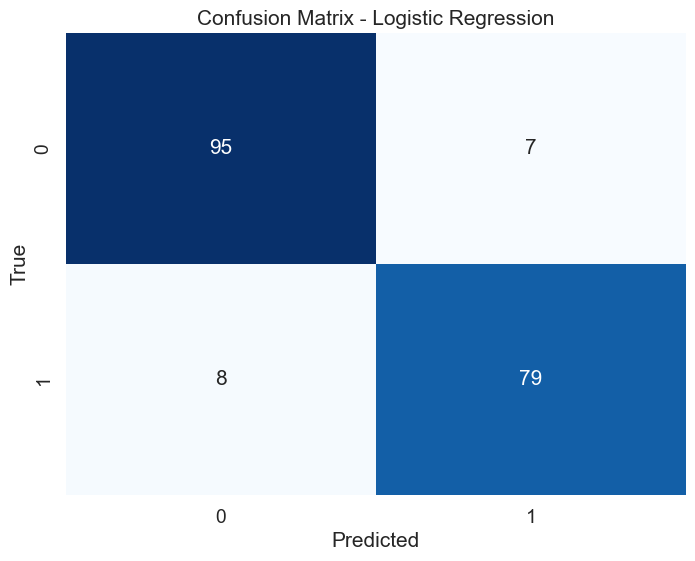

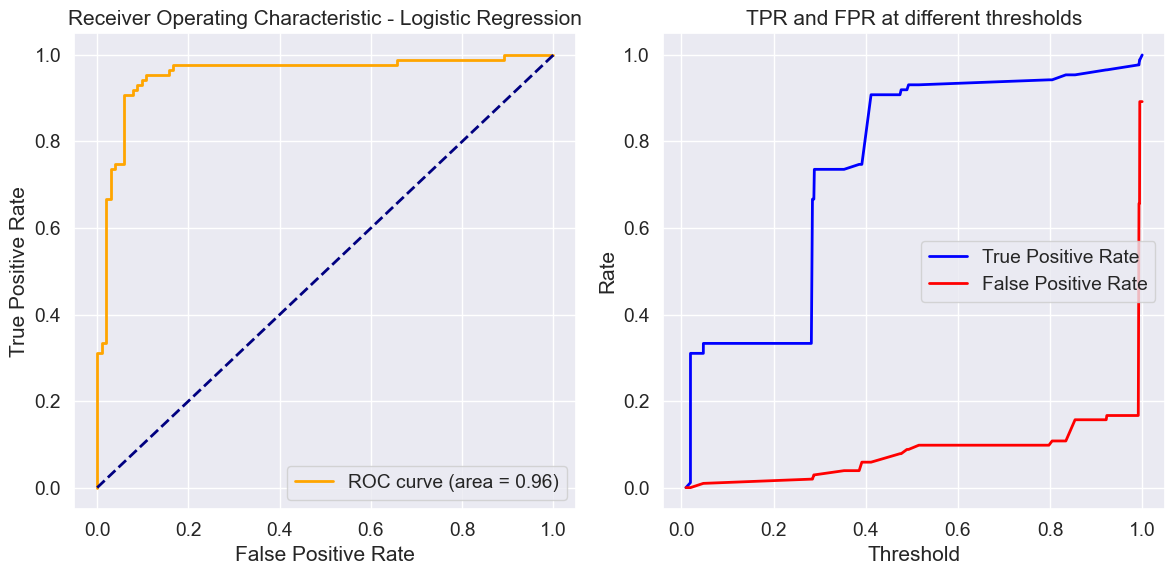

Going through each model defined in the dictionnary...: 100%|██████████| 1/1 [00:16<00:00, 16.08s/it]

Model: Logistic Regression
Accuracy: 0.9206349206349206
Precision: 0.9186046511627907
Recall: 0.9080459770114943
ROC-AUC: 0.9554879423033581




Pour la base test le score est: 0.8774193548387097


In [21]:
from sklearn.model_selection import train_test_split
import random
#random.seed(0)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=200)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10) # avant 40 10 90%, 10 10 200  91%, 
display_results(dict_models, X_train, y_train, X_test, y_test, cv, 'f1 scoring on farm data(%)')

### Metrics to evaluate our models

### Logistic regression
- **Accuracy**: we reach nearly 87% of accuracy on our testing data.

- **Precision**: the model is able to correctly identify all positive instances with a precision score above 90%.

- **F1 Score**: the F1 score is a harmonic mean of precision and recall, which gives equal weight to both false posit.

- **ROC-AUC**: AUC is above 95%, indicating that our model performs well.

In [22]:
farm_test =pd.read_csv('farm_data_test.csv')
farm_test.head()

R2      R14     R17     R32
0  0.837  0.07867  0.1110  0.3084
1  0.451  0.27970  0.0437  0.3479
2  0.230  0.90930  0.0562  0.1669
3  0.000  1.79410  0.1060 -0.0979
4  0.316  0.33330  0.0825  0.3357

### After robust scaling

In [23]:
Xr = robust # 'R17','R32', R14, R2
Yr = farm['DIFF'] #Target

Going through each model defined in the dictionnary...:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


c:\Users\naim\Desktop\Binary-classification\classification_workflow.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


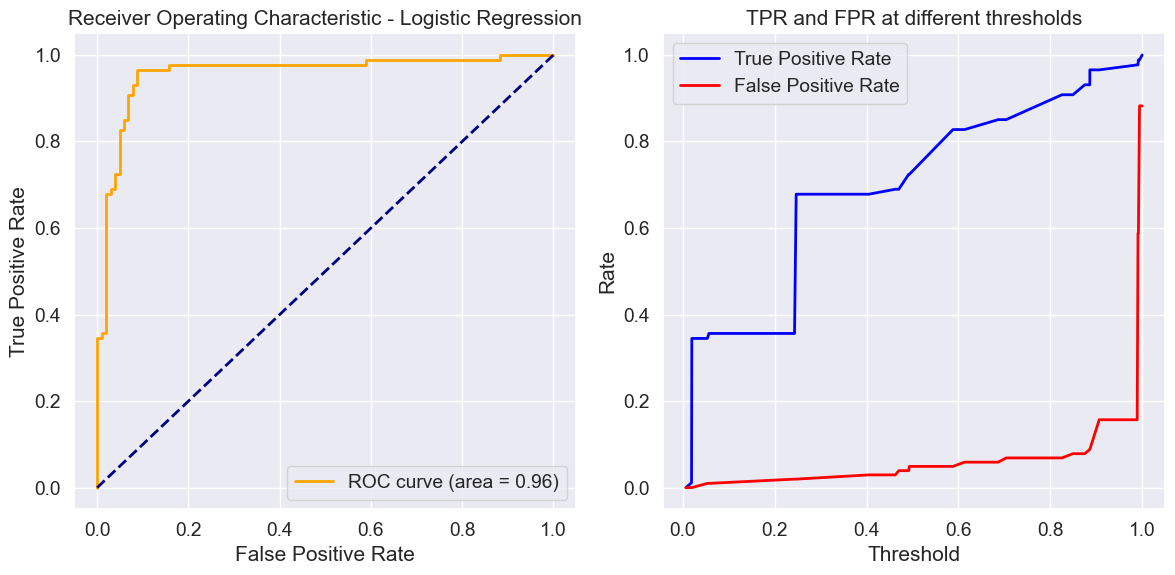

Going through each model defined in the dictionnary...: 100%|██████████| 1/1 [00:08<00:00,  8.35s/it]

Model: Logistic Regression
Accuracy: 0.91005291005291
Precision: 0.9166666666666666
Recall: 0.8850574712643678
ROC-AUC: 0.9579670948839307


Pour la base test le score est: 0.8194444444444444


In [24]:
from sklearn.model_selection import train_test_split
Xr_train,Xr_test,yr_train,yr_test = train_test_split(Xr,Yr,test_size=.20,random_state=200)
cvr = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, Xr_train, yr_train, Xr_test, yr_test, cvr, 'f1 scoring on farm data(%)')

### After standard scaling

In [25]:
Xs = standard # 'R17','R32', R14, R2
Ys = farm['DIFF'] #Target


Going through each model defined in the dictionnary...:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


c:\Users\naim\Desktop\Binary-classification\classification_workflow.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


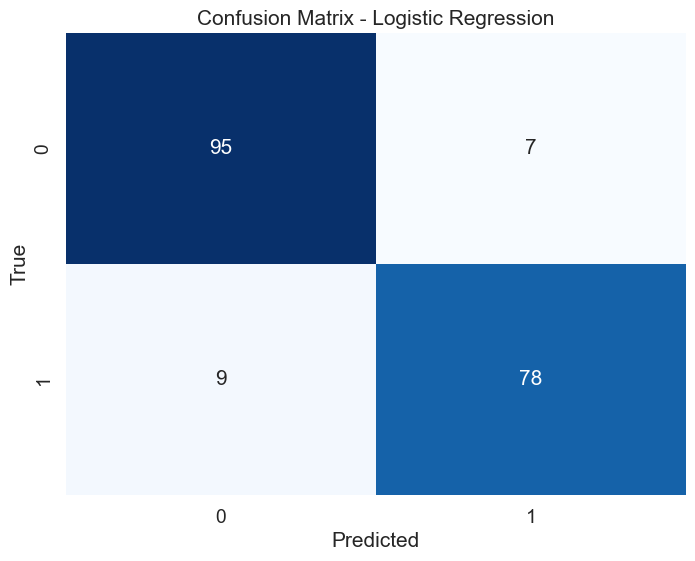

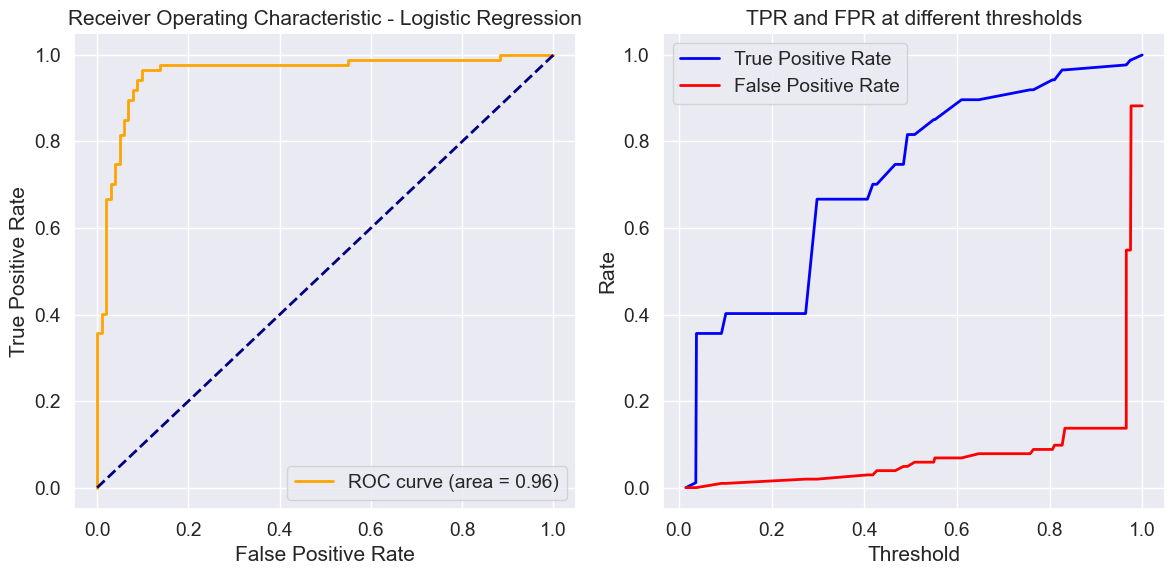

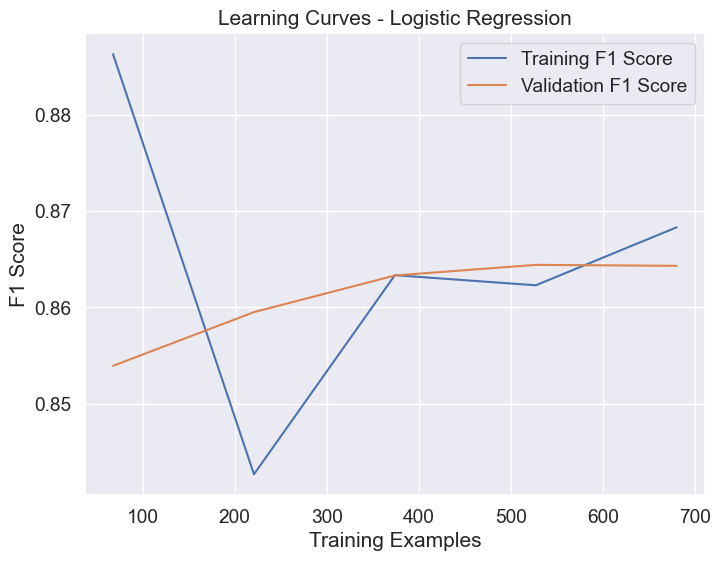

Going through each model defined in the dictionnary...: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]

Model: Logistic Regression
Accuracy: 0.9153439153439153
Precision: 0.9176470588235294
Recall: 0.896551724137931
ROC-AUC: 0.9588686049132298


Pour la base test le score est: 0.8670520231213873


In [26]:
from sklearn.model_selection import train_test_split
Xs_train,Xs_test,ys_train,ys_test = train_test_split(Xs,Ys,test_size=.20,random_state=200)
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, Xs_train, ys_train, Xs_test, ys_test, cvs, 'f1 scoring on farm data(%)')

### After Min-Max scaling

In [27]:
Xm = minmax # 'R17','R32', R14, R2
Ym = farm['DIFF'] #Target


Going through each model defined in the dictionnary...:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


c:\Users\naim\Desktop\Binary-classification\classification_workflow.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


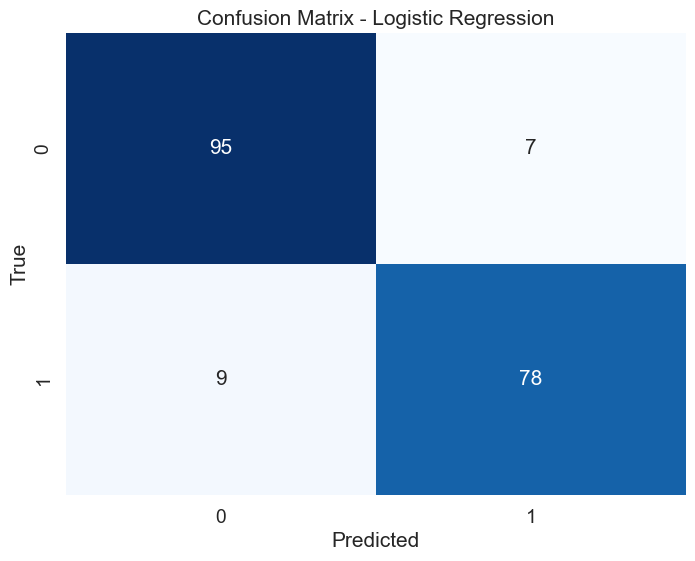

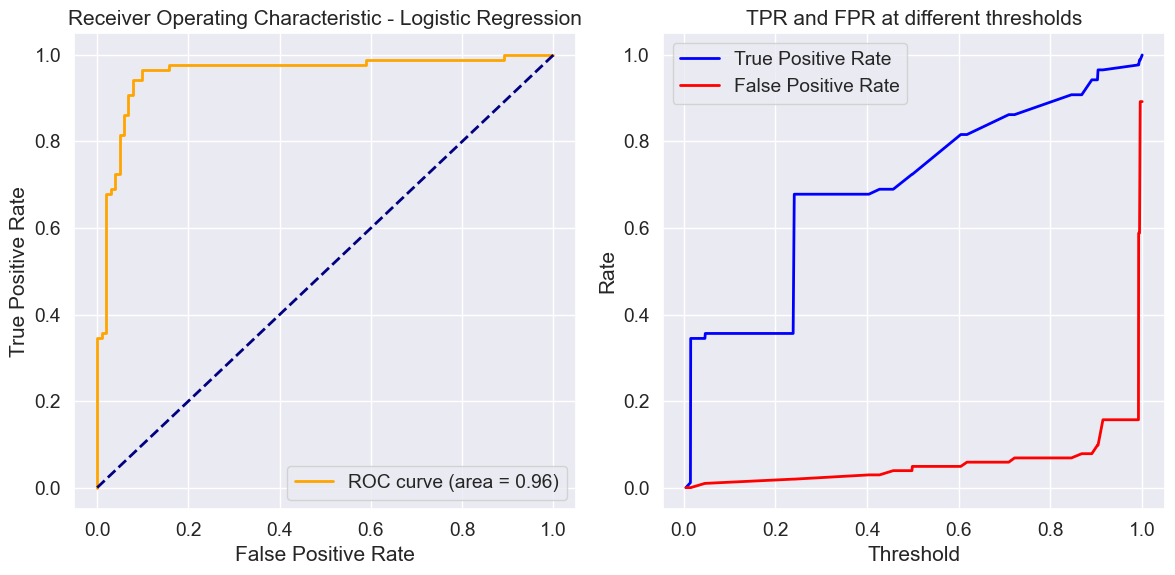

Going through each model defined in the dictionnary...: 100%|██████████| 1/1 [00:06<00:00,  6.64s/it]

Model: Logistic Regression
Accuracy: 0.9153439153439153
Precision: 0.9176470588235294
Recall: 0.896551724137931
ROC-AUC: 0.9577417173766059


Pour la base test le score est: 0.8522727272727273


In [28]:
from sklearn.model_selection import train_test_split
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,Ym,test_size=.20,random_state=200)
cvm = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, Xm_train, ym_train, Xm_test, ym_test, cvm, 'f1 scoring on farm data(%)')

# PCA

In [29]:
column_values = []
#print(farm)
farm1 = farm.drop(['DIFF'], axis=1)  
for i in range(len(farm1.columns)):
    column_values.append(farm1.iloc[:,i].values)
    
#Making Covariance Matrix
covariance_matrix = np.cov(column_values)

#Getting the EigenVectors and the EigenValues
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)


In [30]:
print("Shape of eigenvalues:", eigen_values.shape)
print("Shape of eigenvectors:", eigen_vectors.shape)
print("Shape of covariance matrix:", covariance_matrix.shape)

Shape of eigenvalues: (4,)
Shape of eigenvectors: (4, 4)
Shape of covariance matrix: (4, 4)


In [31]:
covariance_matrix[0]
print(len(eigen_values))
print(eigen_values)

4
[0.44050821 0.04886159 0.00905255 0.00059051]


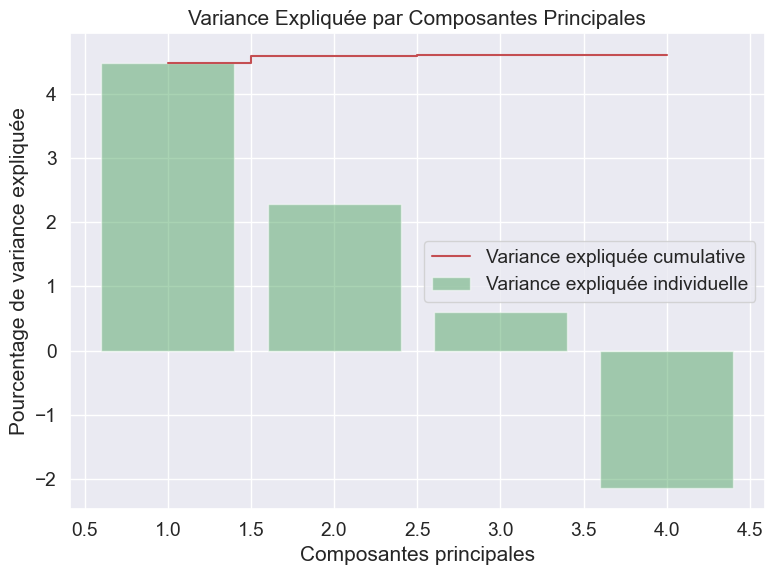

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de valeurs pour les valeurs propres
#eigen_values = np.array([2.9, 1.6, 0.7, 0.3])  # Ces valeurs devraient être fournies par votre calcul PCA

# Calcul de la variance totale
total_variance = np.sum(eigen_values)

# Calcul de la variance expliquée individuelle
explained_variance_ratio = eigen_values / total_variance

# Calcul de la variance expliquée cumulative
explained_variance_cumulative = np.cumsum(explained_variance_ratio) * 100

# Tracer la variance expliquée individuelle en fonction de la variance expliquée cumulative
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio)+1), np.log(explained_variance_ratio*100), alpha=0.5, align='center',
        label='Variance expliquée individuelle', color='g')
plt.step(range(1, len(explained_variance_cumulative)+1), np.log(explained_variance_cumulative),
         where='mid', label='Variance expliquée cumulative', color='r')
plt.ylabel('Pourcentage de variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Variance Expliquée par Composantes Principales')
plt.legend(loc='center right')
plt.tight_layout()
plt.show()


Going through each model defined in the dictionnary...:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 10 folds for each of 48 candidates, totalling 480 fits


c:\Users\naim\Desktop\Binary-classification\classification_workflow.py:102: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([new_row])], ignore_index=True)


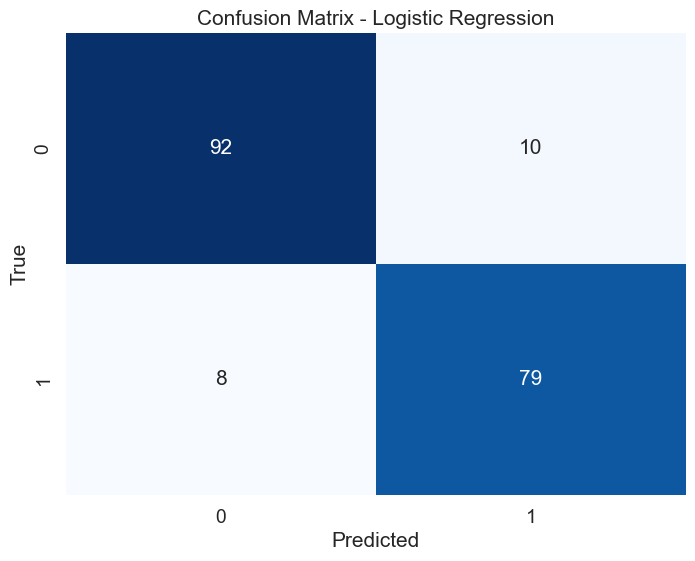

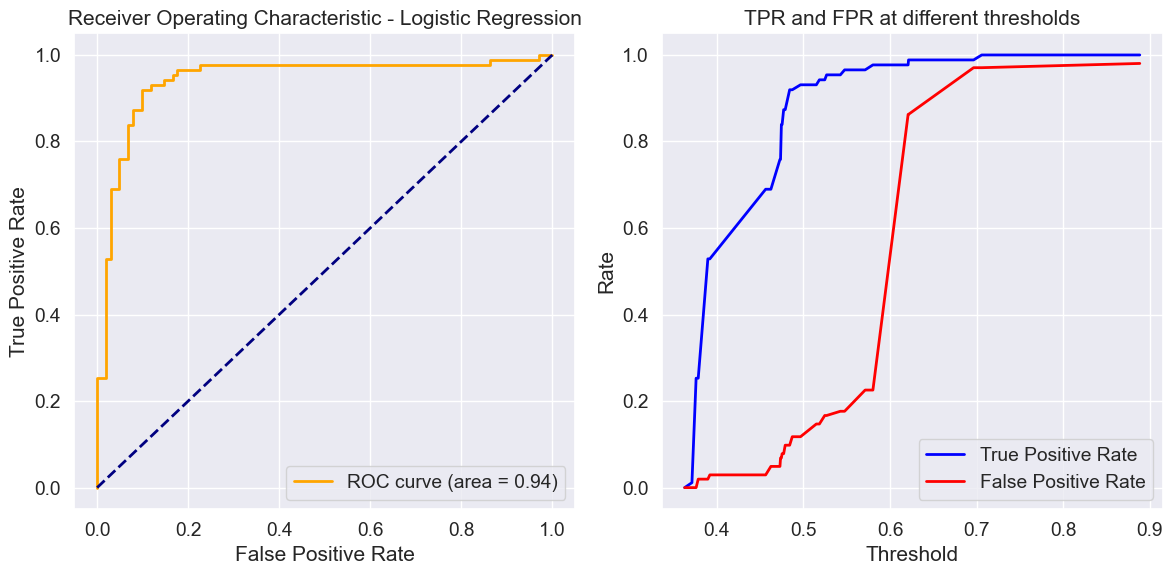

Going through each model defined in the dictionnary...:   0%|          | 0/1 [00:08<?, ?it/s]

Model: Logistic Regression
Accuracy: 0.9047619047619048
Precision: 0.8876404494382022
Recall: 0.9080459770114943
ROC-AUC: 0.9430921794004957




ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- R17
- R32


In [33]:
X1 = farm.drop(['DIFF', 'R17','R32'], axis=1)   # 'R17','R32', R14, R2
Y1 = farm['DIFF'] #Target

from sklearn.model_selection import train_test_split
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,Y1,test_size=.20,random_state=200)
cvs = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
display_results(dict_models, X1_train, y1_train, X1_test, y1_test, cvs, 'f1 scoring on farm data(%)')

In [ ]:
print(farm.columns)

Index(['R2', 'R14', 'R17', 'R32', 'DIFF'], dtype='object')


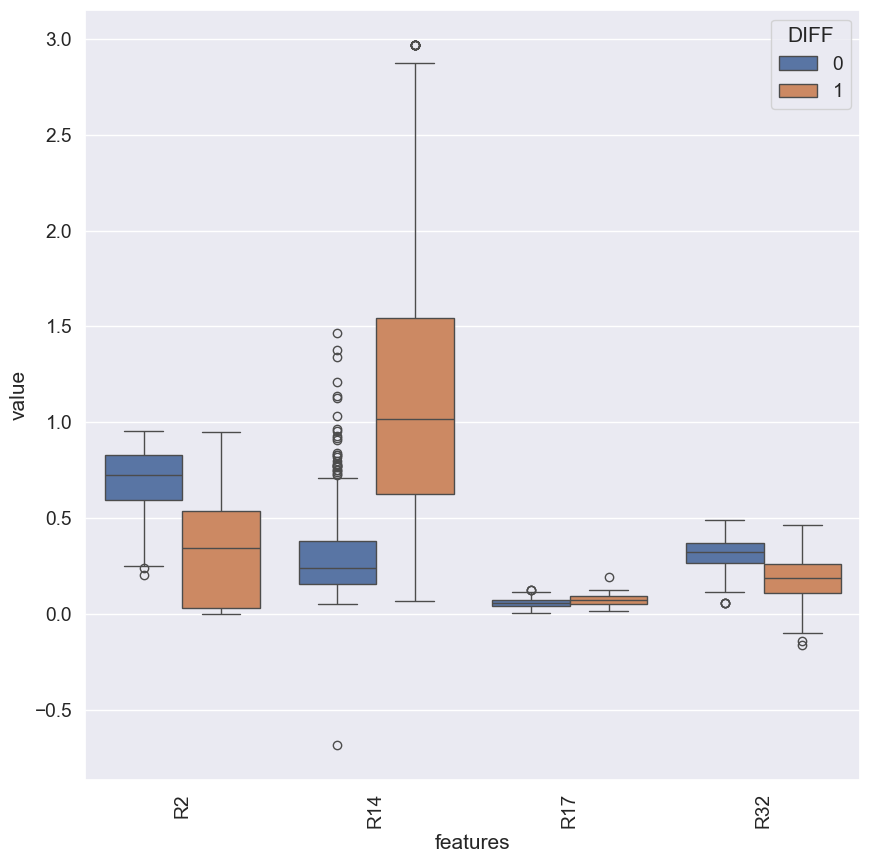

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to convert it from wide format to long format
farm_melted = farm.melt(id_vars='DIFF', value_vars=['R2', 'R14', 'R17', 'R32'], 
                        var_name='features', value_name='value')

# Create the boxplot
plt.figure(figsize=(10, 10))
sns.boxplot(x='features', y='value', hue='DIFF', data=farm_melted)
plt.xticks(rotation=90)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = farm.drop('DIFF', axis=1)
y = farm["DIFF"]

X = StandardScaler().fit_transform(X)  # Standardizing the values in X.

pca = PCA()  # Changes in variance percentage can be made here.
prin_comp = pca.fit_transform(X)
principalDf = pd.DataFrame(data = prin_comp)

print(principalDf)

print('\nEigenvalues \n%s' %pca.explained_variance_)
print('Eigenvectors \n%s' %pca.components_)

            0         1         2         3
0   -1.257662  0.552431  0.577924 -0.413483
1   -1.309423 -0.305079 -0.060353  0.513466
2   -1.623219 -0.059665  0.815067 -0.192541
3   -2.199921 -0.841798  0.569404  0.029673
4   -0.977871 -0.911803  0.735478 -1.053658
..        ...       ...       ...       ...
940  1.174968 -1.492281 -0.102431 -0.102210
941  3.259933 -0.478006  0.121131  0.169908
942  2.124810 -0.644348  0.322364 -0.542001
943  3.265472 -0.463576  0.121562  0.169265
944 -0.179493 -0.307082 -0.130366  0.563369

[945 rows x 4 columns]

Eigenvalues 
[2.28132215 0.81409069 0.51501905 0.3938054 ]
Eigenvectors 
[[-0.54669709  0.55035241  0.35788535 -0.51976206]
 [ 0.25238519 -0.19203942  0.93242534  0.17322111]
 [-0.36722084  0.40669076  0.02784201  0.83604803]
 [ 0.70892374  0.7034456  -0.04154369 -0.02942007]]


## Critere de Kaiser

In [ ]:
def scree_plot():
    from matplotlib.pyplot import figure, show
    from matplotlib.ticker import MaxNLocator

    ax = figure().gca()
    ax.plot(pca.explained_variance_)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1, linewidth=1, color='r', alpha=0.5)
    plt.title('Scree Plot of PCA: Component Eigenvalues')
    show()

scree_plot()

In [ ]:
##On réduit la data into two dimension
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Saine')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Défaillant')
#plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='R17')
plt.legend(loc=0);

## QDA

SyntaxError: invalid syntax (3967299543.py, line 1)

In [ ]:
from pycaret.classification import *
model_qda_MCC = tune_model(create_model('qda'),optimize = 'MCC')
model_qda_MCC 

ModuleNotFoundError: No module named 'pycaret'